## In this notebook we will build the model and see some predicted examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("./dataset/cleaned_news_summary.csv")
data.head()

,Unnamed: 0,text,summary
0,0,administration union territory daman diu revok...,sostok daman diu revokes mandatory rakshabandh...
1,1,malaika arora slammed instagram user trolled d...,sostok malaika slams user who trolled her for ...
2,2,indira gandhi institute medical sciences igims...,sostok virgin now corrected to unmarried in ig...
3,3,lashkaretaibas kashmir commander abu dujana ki...,sostok aaj aapne pakad liya let man dujana bef...
4,4,hotels maharashtra train staff spot signs sex ...,sostok hotel staff to get training to spot sig...


#### Splitting the dataset in the train and validation

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.text, data.summary, test_size=0.2, random_state=101, shuffle=True)

### Loading all the tensorflow libraries for model building

In [7]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from attention_my import AttentionLayer


import warnings

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

In [8]:
physical_devices = tf.config.list_physical_devices("GPU")
physical_devices
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# run_opts = tf.Run(report_tensor_allocations_upon_oom = True)

### Next converting text to sequence of numbers

In [9]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))

In [10]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [11]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

X_train_seq = X_tokenizer.texts_to_sequences(X_train)
X_test_seq = X_tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train_seq, maxlen = max_len_news, padding='post')
X_test = pad_sequences(X_test_seq, maxlen = max_len_news, padding='post')

news_vocab_size = len(X_tokenizer.word_index) + 1

In [12]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [13]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [14]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train_seq, maxlen=max_len_headline, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_len_headline, padding='post')
y_voc_size = len(y_tokenizer.word_index) + 1

In [15]:
y_tokenizer.word_counts['eostok'], len(y_train)

(3516, 3516)

### Model Building and Training

In [18]:
from keras import backend as K
K.clear_session()

latent_dim=300
emb_dim=100

enc_inputs = Input(shape=(max_len_news,))
embedding1 = Embedding(news_vocab_size,emb_dim, trainable=True)(enc_inputs)

lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
enc_output1, h1, c1 = lstm1(embedding1)

lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True, dropout=0.3, recurrent_dropout=0.2)
enc_output2, h2, c2 = lstm2(enc_output1)

lstm3 = LSTM(latent_dim, return_sequences=True,return_state=True, dropout=0.3, recurrent_dropout=0.2)
enc_outputs, h3, c3 = lstm3(enc_output2)


decoder_inputs = Input(shape=(None, ))
dec_embedding = Embedding(y_voc_size, emb_dim, trainable=True)
dec_emb_out = dec_embedding(decoder_inputs)

dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_outputs, fwd_state, back_state = dec_lstm(dec_emb_out, initial_state = [h3, c3])



attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_state = attn_layer([enc_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([enc_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 47, 100)      1946400     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 47, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [19]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [20]:
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

In [21]:

history=model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,batch_size=64, callbacks=[es, rl, mc], validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 6.4889 - accuracy: 0.2007
Epoch 1: val_accuracy improved from -inf to 0.32576, saving model to checkpoint\
INFO:tensorflow:Assets written to: checkpoint\assets
55/55 [==============================] - 45s 672ms/step - loss: 6.4889 - accuracy: 0.2007 - val_loss: 5.0628 - val_accuracy: 0.3258 - lr: 0.0010
Epoch 2/50
55/55 [==============================] - ETA: 0s - loss: 5.8868 - accuracy: 0.2696
Epoch 2: val_accuracy improved from 0.32576 to 0.35985, saving model to checkpoint\
INFO:tensorflow:Assets written to: checkpoint\assets
55/55 [==============================] - 36s 657ms/step - loss: 5.8868 - accuracy: 0.2696 - val_loss: 4.8986 - val_accuracy: 0.3598 - lr: 0.0010
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 5.6950 - accuracy: 0.2804
Epoch 3: val_accuracy did not improve from 0.35985
55/55 [==============================] - 30s 549ms/step - loss: 5.6950 - accuracy: 0.2804 - val_loss: 4.91

##### As we notice that we get the final accuracy of 78.4 %

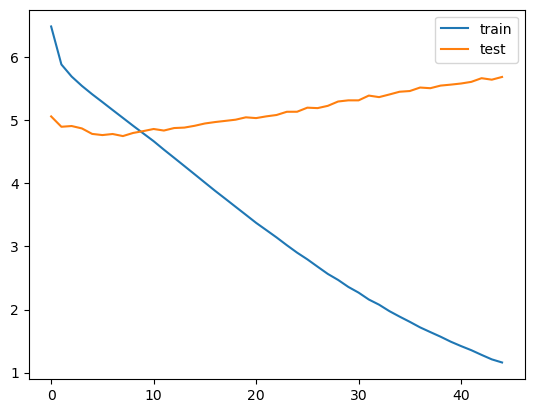

In [22]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()


In [23]:
reverse_target_word_index = y_tokenizer.index_word
reverse_news_words_index = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index


## Inference Model

In [24]:
encoder_model = Model(inputs = enc_inputs, outputs = [enc_outputs, h3, c3])

decoder_h = Input(shape=(latent_dim,))
decoder_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_news, latent_dim))


dec_emb2 = dec_embedding(decoder_inputs)

dec_output2, dec_h2, dec_c2 = dec_lstm(dec_emb2, initial_state=[decoder_h, decoder_c])




attn_out_inf, attn_state_inf = attn_layer([decoder_hidden_state_input, dec_output2])

dec_inf_concat = Concatenate(axis=-1, name='concat')([dec_output2, attn_out_inf])


dec_output2 = decoder_dense(dec_inf_concat)


decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_h, decoder_c], [dec_output2] + [dec_h2, dec_c2])

In [25]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    776200      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                            

### Function to predict

In [26]:
def decode_sequence(input_sequence):
    e_out, e_h, e_c = encoder_model(input_sequence)

    target_seq = np.zeros((1,1))

    target_seq[0,0] = target_word_index['sostok'] ## We always start with sostok

    stop_condition = False


    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        sample_token_index = np.argmax(output_tokens[0,-1,:])
        sampled_token = reverse_target_word_index[sample_token_index]

        if sampled_token!='eostok':
            decoded_sentence+= ' ' + sampled_token

        if (sampled_token=='eostok' or len(decoded_sentence.split())>=(max_len_headline-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))

        target_seq[0,0] = target_word_index[sampled_token]


        e_h, e_c = h, c

    return decoded_sentence


In [27]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_news_words_index[i]+' '
    return newString

## Lets look at some examples

In [30]:
for i in range(1, 4):
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,max_len_news)))
  print("\n")

Review: six months stabbed left playing hand czech tennis player petra kvitova first tournament classic sunday world number 12 kvitova playing second tournament since december incident beat australian 46 63 63 birmingham kvitova returned action french open late may 
Original summary: czech tennis player wins title months after being stabbed 
1/1 [==============================] - 0s 18ms/step
Predicted summary:  what is hold icj from icj in icj in jadhav


Review: farmers 78 villages maharashtra reportedly planning go indefinite fast protest alleged acquisition farm land industrial corridor despite project getting scaled original size 78 villages activists said officials maintained planning land acquisition 
Original summary: maha farmers to fast to protest land acquisition 
1/1 [==============================] - 0s 18ms/step
Predicted summary:  delhi man to get in protest in delhi bjp


Review: launching desh ka aam scheme thursday pm narendra modi said dream see person wears slippers